69.88855707583086


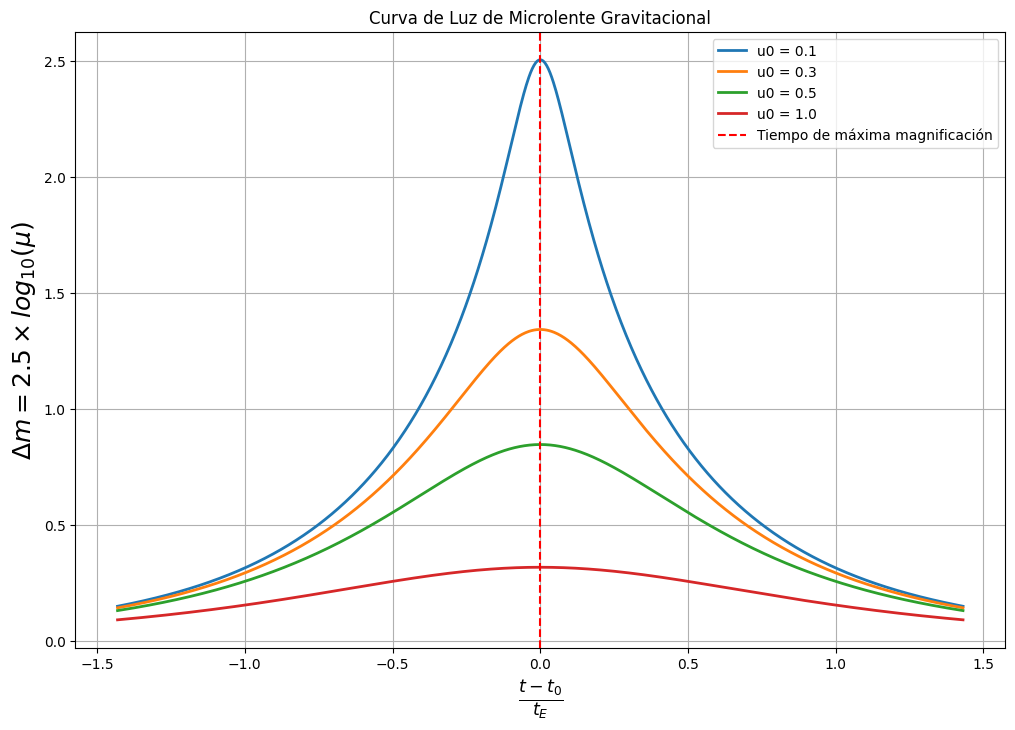

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import G, c, parsec
from functions import magnification

from matplotlib.pyplot import cm
import matplotlib as mpl
from astropy import constants as const
from astropy import units as u
import matplotlib.ticker as ticker
from functions import tterm, shift_par, shift_per, EinsteinCrossTime, theta_e_func


# Parámetros físicos
M_solar = 1.989e30  # Masa solar en kg
D_S = 8 * parsec * 1e3  # Distancia a la fuente en metros (8 kpc)
D_L = 4 * parsec * 1e3  # Distancia a la lente en metros (4 kpc)
v = 100 * 1e3  # Velocidad transversal en m/s

# Cálculo del radio de Einstein
R_E = np.sqrt((4 * G * M_solar * (D_S - D_L) * D_L) / (c**2 * D_S))

# Tiempo de cruce del radio de Einstein (t_E)
t_E = R_E / v / (60 * 60 * 24)  # en días
print(t_E)
# Configuración de tiempo y valores de u0
t0 = 100
time = np.linspace(0, 200, 1000)
u0_values = [0.1, 0.3, 0.5, 1.0]  # Diferentes valores de parametro de impacto

# Graficar la magnificación para diferentes valores de u0
plt.figure(figsize=(12, 8))
for u0 in u0_values:
    magnitudes = magnification(time, t0, t_E, u0)
    plt.plot((time-t0)/t_E, 2.5*np.log10(magnitudes), lw=2, label=f'u0 = {u0}')

# Configuración del gráfico
plt.axvline(x=0, color='red', linestyle='--', label='Tiempo de máxima magnificación')
plt.title('Curva de Luz de Microlente Gravitacional')
plt.xlabel(r'$\frac{t-t_0}{t_E}$',fontsize=18)
# plt.axvspan(-1,1)
plt.ylabel(r'$\Delta m=2.5\times log_{10}(\mu)$',fontsize=18)
# plt.gca().invert_yaxis()
plt.grid(True)
plt.legend()
plt.show()

Text(2, 0.27, '$y_0=2\\sqrt{2}$')

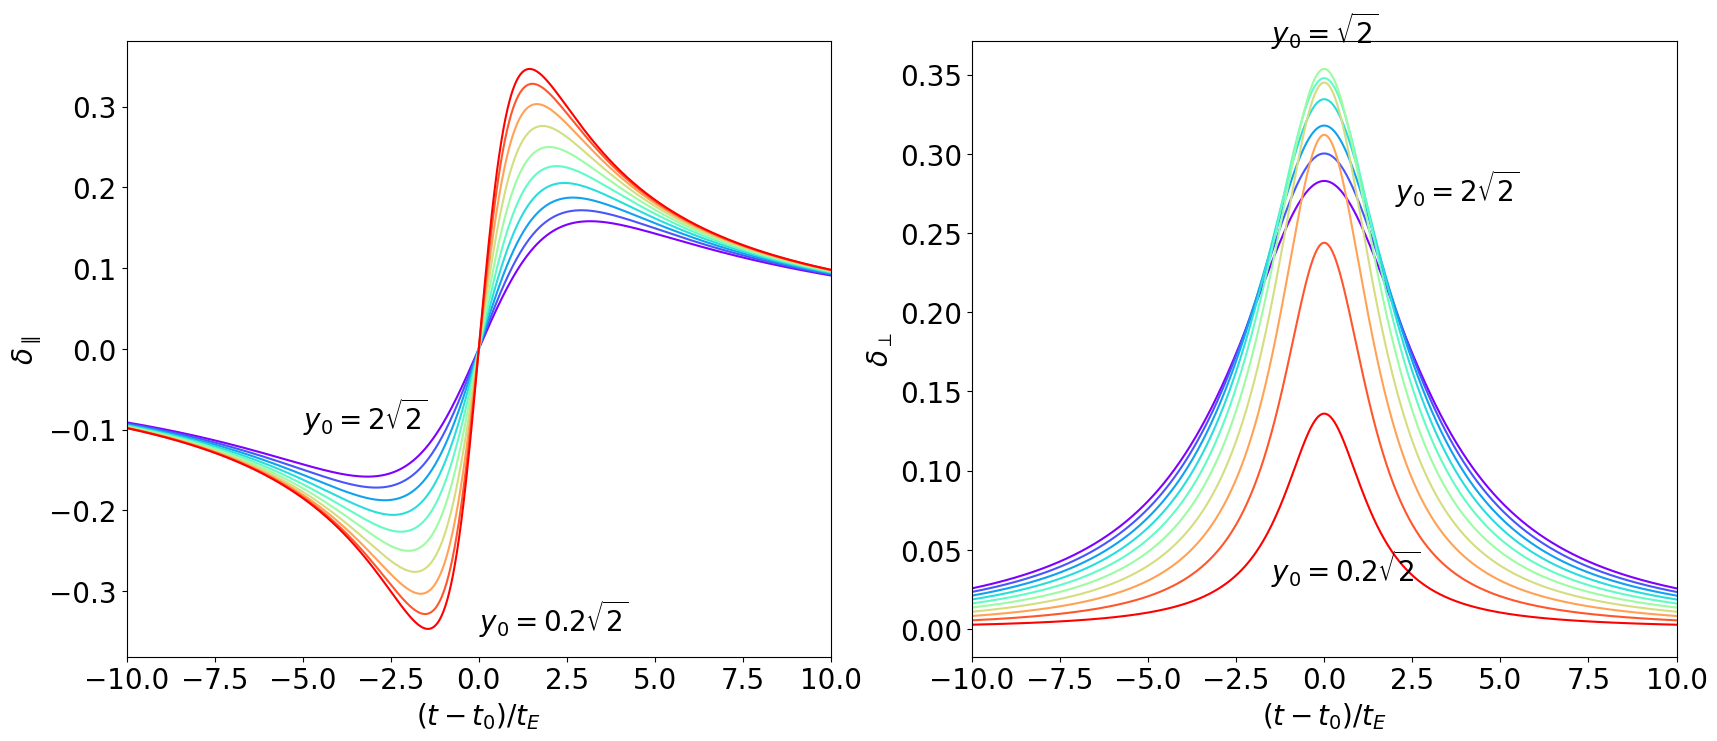

In [2]:

t=np.linspace(0,1830,6400)
M_lens=0.3 # solar masses
DL=4.0 # kpc
DS=8.0 # kpc
vel=200 # km/s
y0=np.linspace(1.0,0.1,10)*2.0*np.sqrt(2.0)
t0=965.0 # days

fig,ax=plt.subplots(1,2,figsize=(20,8))


color=iter(cm.rainbow(np.linspace(0,1,y0.size)))

tt=tterm(M_lens,DL,DS,vel,t0,t)

for i in range(y0.size):
    c=next(color)
    sx=shift_par(M_lens,DL,DS,vel,y0[i],t0,t)
    sy=shift_per(M_lens,DL,DS,vel,y0[i],t0,t)
    ax[0].plot(tt,sx,'-',c=c)
    ax[1].plot(tt,sy,'-',c=c)


ax[0].set_xlim([-10,10])
ax[1].set_xlim([-10,10])
ax[0].xaxis.set_tick_params(labelsize=20)
ax[0].yaxis.set_tick_params(labelsize=20)
ax[1].xaxis.set_tick_params(labelsize=20)
ax[1].yaxis.set_tick_params(labelsize=20)

ax[0].set_xlabel('$(t-t_0)/t_E$',fontsize=20)
ax[1].set_xlabel('$(t-t_0)/t_E$',fontsize=20)
ax[0].set_ylabel('$\delta_{\parallel}$',fontsize=20)
ax[1].set_ylabel('$\delta_{\perp}$',fontsize=20)

ax[0].text(0, -0.35, r'$y_0=0.2\sqrt{2}$', fontsize=20)
ax[0].text(-5, -0.1, r'$y_0=2\sqrt{2}$', fontsize=20)
ax[1].text(-1.5, 0.37, r'$y_0=\sqrt{2}$', fontsize=20)
ax[1].text(-1.5, 0.03, r'$y_0=0.2\sqrt{2}$', fontsize=20)
ax[1].text(2, 0.27, r'$y_0=2\sqrt{2}$', fontsize=20)

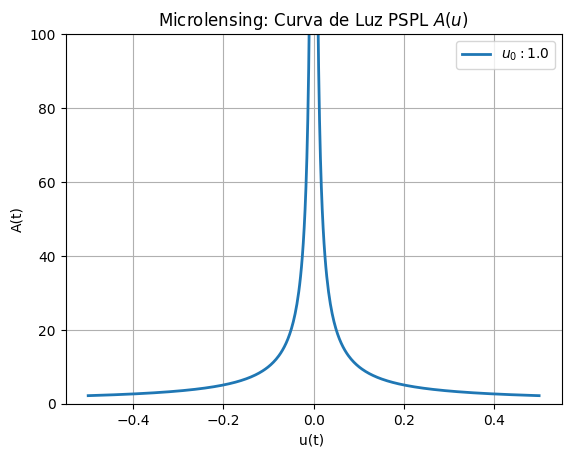

In [3]:
u = np.linspace(-0.5,0.5,500)
mu = lambda u: (u**2 + 2) / (np.abs(u) * np.sqrt(u**2 + 4))
plt.plot(u, mu(u), lw=2, label=r'$u_0:$'+str(u0))
plt.title('Microlensing: Curva de Luz PSPL $A(u)$')
plt.xlabel('u(t) ')
plt.ylabel('A(t)')
plt.ylim(0,100)
plt.grid(True)
plt.legend()
plt.show()


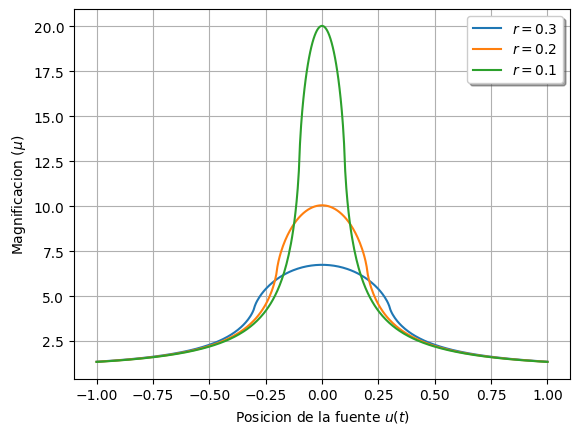

In [4]:
import numpy as np
import mpmath as mpmath
from scipy import integrate

#Codigo sacado del GitHub de CosmoObs (by G. Souza)
@np.vectorize
def magnification_finitesource_A(r, u):

    """
    Funcao que calcula a magnificacao de uma fonte finita analiticamente. Equacoes (9), (11) e (14) do artigo de referencia.

    Args:
      r: raio da fonte (em unidades do raio de einstein)
      u: posição da fonte com relação ao centro da lente (em unidades do raio de einstein)

    """

    #magnificação quando u > r (equacao 9)
    def mag_ur_dif (r, u):

        #argumentos das funcoes elipticas
        n = (4 * u * r)/(u + r)**2
        k = ((4 * n)/(4 + (u - r)**2))

        a = float(mpmath.ellipe(k).real) * ((u + r) / (2 * r**2)) * np.sqrt(4 + (u - r)**2)
        b = float(mpmath.ellipk(k).real) * ((u - r) / (r**2)) * ((4 + (u**2 - r**2)/2) / np.sqrt(4 + (u - r)**2))
        c = float(mpmath.ellippi(n, k))*((2 * (u - r)**2) / (r**2 * (u + r)))*((1 + r**2)/np.sqrt(4 + (u - r)**2))

        mag1 = (1/(2*np.pi))*(+np.pi + a - b + c)
        mag2 = (1/(2*np.pi))*(-np.pi + a - b + c)

        return np.abs(mag1) + np.abs(mag2)

    #magnificaçao quando u = r (equacao 11)
    def mag_ur_iguais (r):

        termo1 = 2/r
        termo2 = (1+r**2)/r**2
        termo3 = np.pi/2 + np.arcsin((r**2 - 1)/(r**2 + 1))

        return (termo1 + termo2*termo3)/np.pi

    #magnificação máxima, lente e fonte perfeitamente alinhadas, u = 0 (equacao 14)
    def mag_u0 (r):

        return np.sqrt(4 + r**2)/r

    if np.abs(u) != r:
        return mag_ur_dif(r, u)


    elif np.abs(u) == 0:
        return mag_u0(r)

    else:
        return mag_ur_iguais(r)

P = np.linspace(-1, 1, 400)
plt.plot(P, magnification_finitesource_A(0.3, P), label='$r = 0.3$') #args: r_s, u
plt.plot(P, magnification_finitesource_A(0.2, P), label='$r = 0.2$')
plt.plot(P, magnification_finitesource_A(0.1, P), label='$r = 0.1$')
plt.legend(fancybox=True, shadow=True)
plt.xlabel('Posicion de la fuente $u(t)$')
plt.ylabel('Magnificacion $(\mu)$')
plt.grid(True)

check_event  : Everything looks fine...
[2457467.9252872667, 0.3332238348397335, 123.54112319978374, 0.03902371284208841, 1395415.142552433, 164.2909031859831]


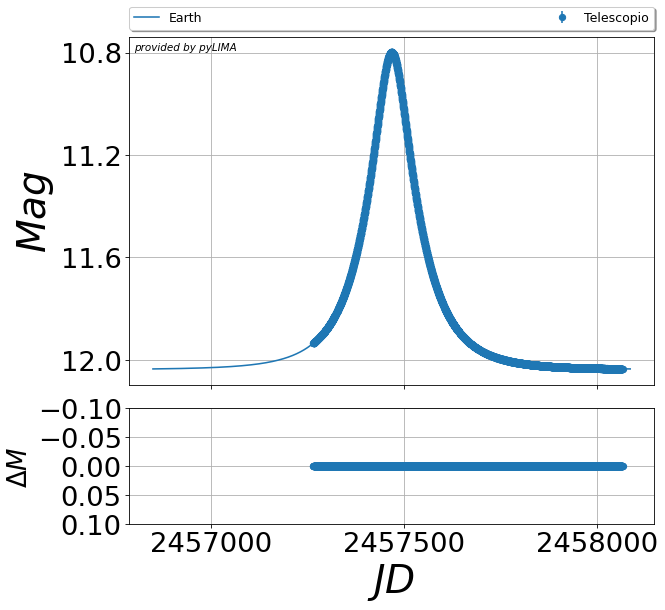

In [5]:
import matplotlib.pyplot as plt
# from pyLIMA.models iamport DSPL_model
from pyLIMA.models import PSPL_model
from pyLIMA.models import FSPLarge_model

from pyLIMA.outputs import pyLIMA_plots
### Import the simulator to be used for generating the simulated light curve
from pyLIMA.simulations import simulator
from pyLIMA.toolbox import brightness_transformation

from pyLIMA import event

your_event = event.Event(ra=270, dec=-30)
your_event.name = 'My simulated event'

telescopio = simulator.simulate_a_telescope(name='Telescopio', time_start=2457365.5-100,
                                        time_end=2457965.5+100, sampling=4,
                                        location='Earth', camera_filter='I',
                                        uniform_sampling=True, astrometry=False)

your_event.telescopes.append(telescopio)
your_event.telescopes[0].ld_gamma = 0.5
# your_event.telescopes[1].ld_gamma = 0.5

your_event.check_event()

pspl = FSPLarge_model.FSPLargemodel(your_event)

pspl_parameters = simulator.simulate_microlensing_model_parameters(pspl)
# pspl_parameters =[2457325,0.1,50,295337.55338102015, 567.8517989006273]
print (pspl_parameters)

pspl.model_dictionnary

pyLIMA_parameters_1 = pspl.compute_pyLIMA_parameters(pspl_parameters)

simulator.simulate_lightcurve_flux(pspl, pyLIMA_parameters_1)

pyLIMA_plots.plot_lightcurves(pspl, pspl_parameters)
plt.show()


Earth
Parallax(Full) estimated for the telescope u: SUCCESS


ValueError: The unit 'JD' is unrecognized.  It can not be converted to other units.

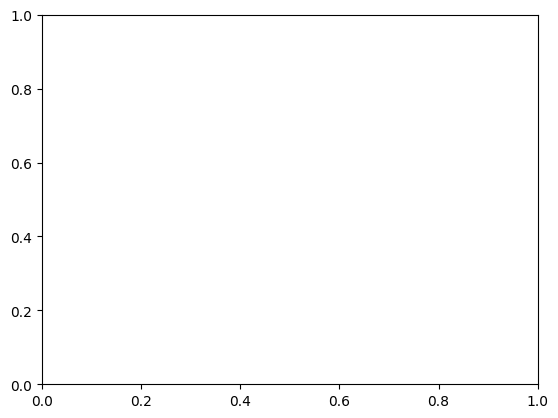

In [6]:
import os
import numpy as np
import pandas as pd
import math
import copy
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord
#---------------------------------------
from pyLIMA.simulations import simulator
from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA.models import PSPL_model
from pyLIMA.models import USBL_model
Ra = 267.92
Dec = -29.15
i=0
my_own_creation = event.Event(ra=Ra, dec=Dec)

my_own_creation.name = 'An event observed by Rubin'

LSST_u = simulator.simulate_a_telescope(name='u', time_start=2457365.5,
                                        time_end=2457965.5, sampling=4,
                                        location='Earth', camera_filter='I',
                                        uniform_sampling=True, astrometry=False)



my_own_creation.telescopes.append(LSST_u)

#coeficiente de limb darkening
my_own_creation.telescopes[0].ld_gamma = 0.5


cero_p = [ 27.03]

new_creation = copy.deepcopy(my_own_creation)

# uniform source with point lens
params = {'t0': (2457365.5+2457965.5)/2, 'u0': 0.01, 'tE': 50,'rho': 0.25,'s': 1,'q': 0.001,'alpha': 3.14,'piEN': 0.3,
          'piEE': 0.1}
t0 = params['t0']

my_own_parameters = []
for key in params:
    my_own_parameters.append(params[key])

my_own_model = USBL_model.USBLmodel(new_creation ,parallax=['Full', t0])
pyLIMA_parameters_1 = my_own_model.compute_pyLIMA_parameters(my_own_parameters)

magstar = [27.94]

fs = []
my_own_flux_parameters = []
np.random.seed(i)
G = []
for m in range(len(magstar)):
    ZP = cero_p[m]
    mag_baseline = magstar[m]
    flux_baseline = 10**((ZP-mag_baseline)/2.5)
    g = np.random.uniform(0,1)
    G.append(g)
    f_source = flux_baseline/(1+g)
    fs.append(f_source)
    my_own_flux_parameters.append(f_source)
    my_own_flux_parameters.append(g)
my_own_parameters += my_own_flux_parameters
pyLIMA_parameters = my_own_model.compute_pyLIMA_parameters(my_own_parameters)
simulator.simulate_lightcurve_flux(my_own_model, pyLIMA_parameters)

for k in range(len(new_creation.telescopes)):
    model_flux = my_own_model.compute_the_microlensing_model(new_creation.telescopes[k],
                                                             pyLIMA_parameters)['photometry']
    new_creation.telescopes[k].lightcurve_flux['flux'] = model_flux

plt.plot(new_creation.telescopes[k].lightcurve_flux['time'],new_creation.telescopes[k].lightcurve_flux['flux'])
plt.xlabel("Time")
plt.ylabel("Flux")
from pyLIMA.outputs import pyLIMA_plots
pyLIMA_plots.plot_geometry(my_own_model, my_own_parameters)
plt.show()